In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

### Cargamos el dataset

In [2]:
df = pd.read_csv('titanic.csv')

Eliminamos las columnas que no son predicturas

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df = df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

Creamos cageogoricas

In [5]:
df = pd.get_dummies(df)
del df['Sex_female']

### Pequeña exploración de datos

In [6]:
df.groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,,,,,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887,0.852459,0.136612,0.085610,0.777778
1,1.950292,28.343690,0.473684,0.464912,48.395408,0.318713,0.271930,0.087719,0.634503


Quitamos los NA's

In [7]:
df.isna().sum()

Survived        0
Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [8]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

### Crea un modelo 

In [9]:
target = 'Survived'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Predicciones del modelo, cuales son los tipos que hay 

In [10]:
probas = model.predict_proba(X_test)

probabilidades = [i[1] for i in probas]
predicciones = model.predict(X_test)

calibracion = pd.DataFrame({
    'target': y_test, 
    'probabilidades': probabilidades, 
    'predicciones': predicciones
})

### Calibracion

In [11]:
calibracion['bins'] = pd.qcut(calibracion['probabilidades'], q=10, labels=False) + 1

grouped = calibracion.groupby('bins').mean()

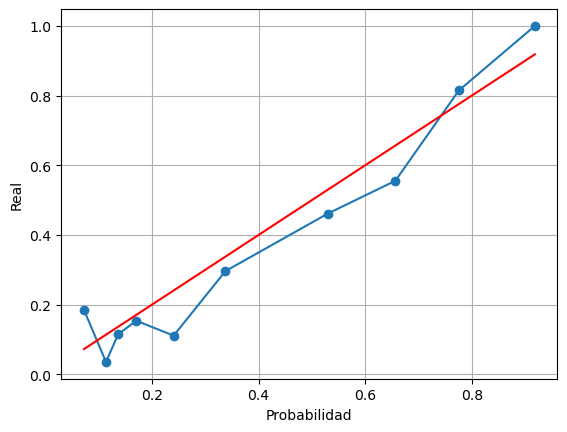

In [12]:
plt.plot(grouped.probabilidades, grouped.target, marker="o")
plt.plot(grouped.probabilidades, grouped.probabilidades, color="red")
plt.xlabel("Probabilidad")
plt.ylabel("Real")
plt.grid();

### ¿Qué tanto le atina?

Con sklearn 

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(calibracion['target'], calibracion['predicciones'])

0.8022388059701493

###  Histogramas 

In [15]:
prob_1 = calibracion.query("target == 1")['probabilidades']
prob_0 = calibracion.query("target == 0")['probabilidades']

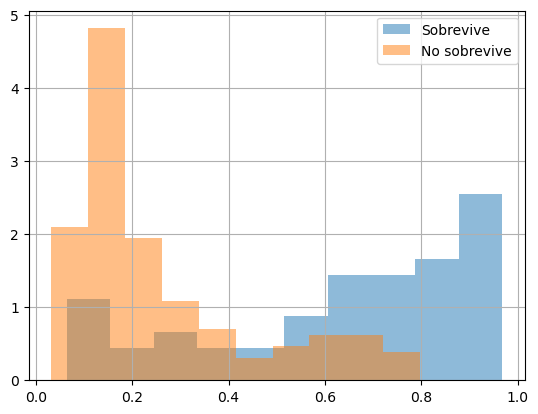

In [16]:
plt.hist(prob_1, alpha = 0.5, density=True, label = 'Sobrevive')
plt.hist(prob_0, alpha = 0.5, density=True, label = 'No sobrevive')
plt.legend()
plt.grid();

### Usando statsmodel

In [22]:
import statsmodels.formula.api as smf
df = pd.read_csv('titanic.csv')

In [23]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [24]:
model = smf.logit('Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)', data=df).fit()

Optimization terminated successfully.
         Current function value: 0.444060
         Iterations 6


In [25]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      702
Method:                           MLE   Df Model:                            9
Date:                Thu, 20 Feb 2025   Pseudo R-squ.:                  0.3419
Time:                        21:25:28   Log-Likelihood:                -316.17
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 2.249e-65
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.4329      0.536      8.271      0.000       3.383       5.483
C(Pclass)[T.2]      -1.1896      0.329     -3.614      0.000      -1.835      -0.544
C(Pclass)[T.3]      -2.3952 